In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import statsmodels.api as sm
import scipy.stats as stats


data_dir = '../data/'

               real  nominal
Date                        
1915-01-01  1723.00    56.54
1915-02-01  1693.46    55.02
                real   nominal
Date                          
2023-10-01  33052.87  33052.87
2023-11-01  34337.87  34337.87


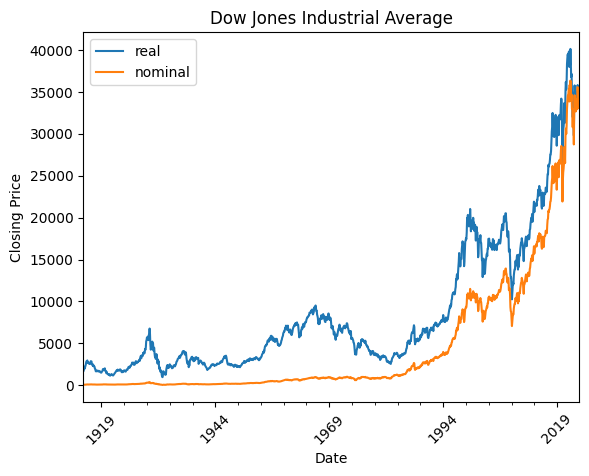

In [2]:
# load stock_data.csv
stock_data = pd.read_csv(data_dir + 'stock_data.csv')
stock_data.set_index('date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)
stock_data.index.name = 'Date'

# plot
stock_data.plot()
plt.xticks(rotation=45)
plt.title('Dow Jones Industrial Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# print head and plot
print(stock_data.head(2))
print(stock_data.tail(2))


In [3]:
# load in CPI data from database
conn = sqlite3.connect('../food_inflation_analysis.db')
query = '''SELECT * FROM OCED_USA_FOOD_INFLATION'''
cpi_food_data = pd.read_sql(query, conn)
cpi_food_data.set_index('Date', inplace=True)
cpi_food_data.index = pd.to_datetime(cpi_food_data.index)
print(cpi_food_data.head(2))
# close connection
conn.close()


            Inflation
Date                 
1956-01-01  -1.700680
1956-02-01  -2.372881


In [4]:
# find correlation between stock_data and cpi_food_data
# merge stock_data and cpi_food_data
stock_cpi_merge = pd.merge(stock_data, cpi_food_data, how='inner', on='Date')
print(stock_cpi_merge.head(2))

# add column for lags of stock_data
stock_cpi_merge['real_lag1'] = stock_cpi_merge['real'].shift(1)
stock_cpi_merge['nominal_lag1'] = stock_cpi_merge['nominal'].shift(1)
print(stock_cpi_merge.head(2))

               real  nominal  Inflation
Date                                   
1956-01-01  5406.45   470.74  -1.700680
1956-02-01  5554.72   483.65  -2.372881
               real  nominal  Inflation  real_lag1  nominal_lag1
Date                                                            
1956-01-01  5406.45   470.74  -1.700680        NaN           NaN
1956-02-01  5554.72   483.65  -2.372881    5406.45        470.74


In [5]:
# drop NaN values then calculate correlation between real_lag1, nominal_lag1 with CPI
stock_cpi_merge.dropna(inplace=True)

# calculate correlation using Spearman correlation
corr_real = stock_cpi_merge['real_lag1'].corr(stock_cpi_merge['Inflation'], method='spearman')
corr_nominal = stock_cpi_merge['nominal_lag1'].corr(stock_cpi_merge['Inflation'], method='spearman')
stock_cpi_merge['ratio'] = stock_cpi_merge['real_lag1'] / stock_cpi_merge['nominal_lag1']
corr_ratio = stock_cpi_merge['ratio'].corr(stock_cpi_merge['Inflation'], method='spearman')
print('Correlation between Dow Jones ratio of real_lag1 and nominal_lag1 and CPI: ', corr_ratio)
print('Correlation between Dow Jones real lag 1 and CPI: ', corr_real)
print('Correlation between Dow Jones nominal lag 1 and CPI: ', corr_nominal)

# using OLS to find statistical significance of these correlations
# get confidence intervals for real_lag1
real_lag1 = stock_cpi_merge['real_lag1']
real_lag1 = sm.add_constant(real_lag1)
model = sm.OLS(stock_cpi_merge['Inflation'], real_lag1)
results = model.fit()
print(results.summary())

# get confidence intervals for nominal_lag1
nominal_lag1 = stock_cpi_merge['nominal_lag1']
nominal_lag1 = sm.add_constant(nominal_lag1)
model = sm.OLS(stock_cpi_merge['Inflation'], nominal_lag1)
results = model.fit()
print(results.summary())


Correlation between Dow Jones ratio of real_lag1 and nominal_lag1 and CPI:  0.09231941900022186
Correlation between Dow Jones real lag 1 and CPI:  -0.3062970933536437
Correlation between Dow Jones nominal lag 1 and CPI:  -0.1438974746560042
                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     22.04
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           3.14e-06
Time:                        12:11:21   Log-Likelihood:                -2213.0
No. Observations:                 812   AIC:                             4430.
Df Residuals:                     810   BIC:                             4439.
Df Model:                           1                                         
Covariance Type:            nonrobust           

In [6]:
# create dataframe for real stock data
real_stock_data = pd.DataFrame()
real_stock_data['real-price'] = stock_data['real']
print(real_stock_data.head(2))

# save to database
conn = sqlite3.connect('../food_inflation_analysis.db')

real_stock_data.to_sql('DOW_JONES_REAL', conn, if_exists='replace')

            real-price
Date                  
1915-01-01     1723.00
1915-02-01     1693.46


1307

In [7]:
# varify it is in database
query = '''SELECT * FROM DOW_JONES_REAL'''
real_stock_data = pd.read_sql(query, conn)
print(real_stock_data.head(2))
print(real_stock_data.tail(2))

# query to show tables
query = '''SELECT name FROM sqlite_master WHERE type='table';'''
# execute query
cursor = conn.execute(query)
# get tables
tables = cursor.fetchall()
print(tables)

# close connection
conn.close()

                  Date  real-price
0  1915-01-01 00:00:00     1723.00
1  1915-02-01 00:00:00     1693.46
                     Date  real-price
1305  2023-10-01 00:00:00    33052.87
1306  2023-11-01 00:00:00    34337.87
[('gas_prices',), ('OCED_USA_FOOD_INFLATION',), ('DOW_JONES_REAL',)]


In [13]:
# Analyze lag correlations
lag = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for i in lag:
    corr = stock_cpi_merge['real'].shift(i).corr(stock_cpi_merge['Inflation'], method='spearman')
    print(f'Correlation between dow jones stock price and food inflation with lag {i}: ', corr)
    # get the number of observations
    n = len(stock_cpi_merge['real'].shift(i))

    # get the t critical value
    t_crit = stats.t.ppf(0.975, n-2)

    # get the standard error
    se = np.sqrt((1-corr**2)/(n-2))

    # get the margin of error
    moe = t_crit*se

    # get the confidence interval
    ci = (corr-moe, corr+moe)
    # print('Confidence interval for the correlation: ', ci)

Correlation between dow jones stock price and food inflation with lag 1:  -0.30895208309985506
Correlation between dow jones stock price and food inflation with lag 2:  -0.3029461850514536
Correlation between dow jones stock price and food inflation with lag 3:  -0.29734567974833676
Correlation between dow jones stock price and food inflation with lag 4:  -0.2911390472901949
Correlation between dow jones stock price and food inflation with lag 5:  -0.2838620260712055
Correlation between dow jones stock price and food inflation with lag 6:  -0.2747792109093953
Correlation between dow jones stock price and food inflation with lag 7:  -0.26623391949121195
Correlation between dow jones stock price and food inflation with lag 8:  -0.25933168839269727
Correlation between dow jones stock price and food inflation with lag 9:  -0.2524715073786859
Correlation between dow jones stock price and food inflation with lag 10:  -0.24412236270611157
Correlation between dow jones stock price and food inf